In [74]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from math import pi
from math import e
from numpy import sin
from numpy import cos
from cmath import sqrt
from scipy import special
from numpy import exp
from scipy import optimize
from numpy import log
from numpy import tanh
from scipy.optimize import fsolve
from scipy.optimize import brentq
from numpy import conj

In [60]:
steps = 100
convergence = 100
w_list = np.linspace(-10.0, 10.0, num=steps)
tol = 0.001

In [61]:
def Greal_R(w,sigma,U):
    tol = 0.00001
    result = 0*1j
    factor = w + U/2 - sigma
    result_positive = factor / 2 + 0.5 * sqrt(factor ** 2 - 4)
    #print(result_positive)
    result_negative = factor / 2 - 0.5 * sqrt(factor ** 2 - 4)
    #print(result_negative)
    if result_positive.imag < (-1*tol):
        result = result_positive
    elif result_negative.imag < (-1*tol):
        result = result_negative
    else:
        if abs(result_positive) < 1:
            result = result_positive
        elif abs(result_negative) < 1:
            result = result_negative
        else:
            result = -1
            #print('hey weirdo.')
    return result

def Greal_0(w,sigma,U):
    return 1 / (1/Greal_R(w,sigma,U) + sigma)

def Greal_new(w,sigma,U):
    return 0.5 * Greal_0(w,sigma,U) + 0.5 * 1/(1/Greal_0(w,sigma,U) - U)

In [92]:
def get_gf(w,U):
    retardedreal = 0*1j
    #retardedimag_list = []
    tol = 0.001
    sigma_temp = 0.0
    old_sigma = sigma_temp
    retarded = Greal_R(w, sigma_temp, U)
    #print(retarded)
    nonint = 1/(1/retarded + old_sigma)
    new = 0.5 * nonint + 0.5 * 1/(1/nonint - U)
    new_sigma = 1 / nonint - 1 / new
    
    for i in range(convergence):
        old_sigma = new_sigma
        retarded = Greal_R(w, old_sigma, U)
        #print(w_list[i],retarded)
        nonint = 1/(1/retarded + old_sigma)
        new = 0.5 * nonint + 0.5 * 1/(1/nonint - U)
        new_sigma = 1 / nonint - 1 / new
    #sigma_list.append(new_sigma)
    #print('Sigma = ',sigma_list[i])
    retardedreal = Greal_R(w, new_sigma, U)
    return retardedreal

def get_sigma(w,U):
    retardedreal = 0*1j
    #retardedimag_list = []
    tol = 0.001
    sigma_temp = 0.0
    old_sigma = sigma_temp
    retarded = Greal_R(w, sigma_temp, U)
    #print(retarded)
    nonint = 1/(1/retarded + old_sigma)
    new = 0.5 * nonint + 0.5 * 1/(1/nonint - U)
    new_sigma = 1 / nonint - 1 / new
    
    for i in range(convergence):
        old_sigma = new_sigma
        retarded = Greal_R(w, old_sigma, U)
        #print(w_list[i],retarded)
        nonint = 1/(1/retarded + old_sigma)
        new = 0.5 * nonint + 0.5 * 1/(1/nonint - U)
        new_sigma = 1 / nonint - 1 / new
    #sigma_list.append(new_sigma)
    #print('Sigma = ',sigma_list[i])
    #retardedreal = Greal_R(w, new_sigma, U)
    return new_sigma

def sigma_0(U,T):
    w_start = -3
    w_stop = 3
    w_interval = (w_stop - w_start) / steps
    e_start = -1.99
    e_stop = 1.99
    e_interval = (e_stop - e_start) / steps
    integral_value = 0*1j
    w = w_start + 0.5 * w_interval
    e = e_start + 0.5 * e_interval
    
    for i in range(steps):
        inner_integral = 0*1j
        for j in range(steps):
            inner_integral += sqrt(4-e**2)/(2*pi) * 1/3 * (4-e**2) * (-1/pi)**2 * ((1/(w+(U/2)-e-get_sigma(w,U))).imag)**2 * e_interval
            e += e_interval
        integral_value += (exp(w/T)/T) / (1+exp(w/T))**2 * inner_integral * w_interval
        w += w_interval
        
    return integral_value * e**2 * pi

In [78]:
def sigma(v,U,T):
    integral_value = 0*1j
    startpoint = -3
    endpoint = 3
    interval = (endpoint - startpoint) / steps
    w = startpoint + 0.5 * interval
    
    for i in range(steps):
        smaller_part_1 = 4/3*get_gf(w,U) + 1/3*(w+(U/2)-get_sigma(w,U)) - 1/3*(w+(U/2)-get_sigma(w,U))**2 * get_gf(w,U)
        smaller_part_2 = 4/3*get_gf(w+v,U) + 1/3*(w+v+(U/2)-get_sigma(w+v,U)) - 1/3*(w+v+(U/2)-get_sigma(w+v,U))**2 * get_gf(w+v,U)
        smaller_part_2_conj = 4/3*conj(get_gf(w+v,U)) + 1/3*(w+v+(U/2)-conj(get_sigma(w+v,U))) - 1/3*(w+v+(U/2)-conj(get_sigma(w+v,U)))**2 * conj(get_gf(w+v,U))
        fraction = 1/(v+get_sigma(w,U)-get_sigma(w+v,U))
        fraction_conj = 1/(v+get_sigma(w,U)-conj(get_sigma(w+v,U)))
        sum_over_k = (-1/(2*(pi**2))) * (fraction * (smaller_part_1 - smaller_part_2) - fraction_conj * (smaller_part_1 - smaller_part_2_conj)).real
        
        fermi = 1/(1+exp(w/T))
        fermi_shift = 1/(1+exp((w+v)/T))
        
        integral_value += (fermi - fermi_shift)/v * sum_over_k * interval
        w += interval
    
    return integral_value * e**2 * pi

In [240]:
v_list = np.linspace(0.001,5,num=100)
sigma05001_list = []
sigma0501_list = []
sigma051_list = []
sigma0510_list = []

In [241]:
for i in range(len(v_list)):
    #print(i)
    sigma05001_list.append(sigma(v_list[i], 0.5, 0.01))
    sigma0501_list.append(sigma(v_list[i], 0.5, 0.1))
    sigma051_list.append(sigma(v_list[i], 0.5, 1.0))
    sigma0510_list.append(sigma(v_list[i], 0.5, 10.0))

C:\Users\luoge\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


C:\Users\luoge\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


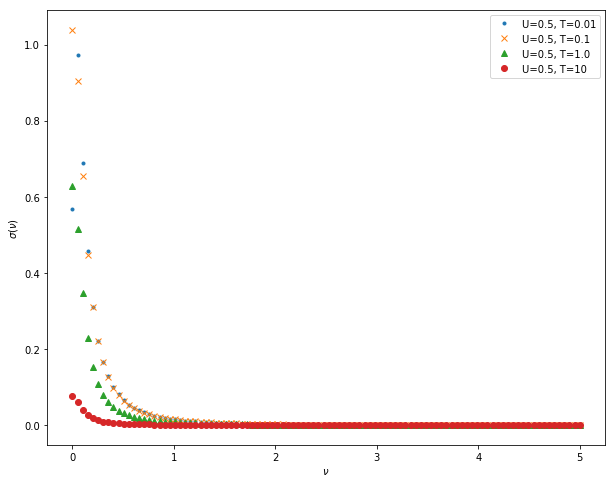

In [244]:
plt.figure(figsize = (10, 8))
plt.ylabel(r'$\sigma(\nu)$')
plt.xlabel(r'$\nu$')
plt.plot(v_list, sigma05001_list, '.', label = 'U=0.5, T=0.01')
plt.plot(v_list, sigma0501_list, 'x', label = 'U=0.5, T=0.1')
plt.plot(v_list, sigma051_list, '^', label = 'U=0.5, T=1.0')
plt.plot(v_list, sigma0510_list, 'o', label = 'U=0.5, T=10')
plt.legend()
plt.show()

In [114]:
sigma1001_list = []
sigma101_list = []
sigma11_list = []
sigma110_list = []

In [115]:
for i in range(len(v_list)):
    #print(i)
    sigma1001_list.append(sigma(v_list[i], 1.0, 0.01))
    sigma101_list.append(sigma(v_list[i], 1.0, 0.1))
    sigma11_list.append(sigma(v_list[i], 1.0, 1.0))
    sigma110_list.append(sigma(v_list[i], 1.0, 10.0))

C:\Users\luoge\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


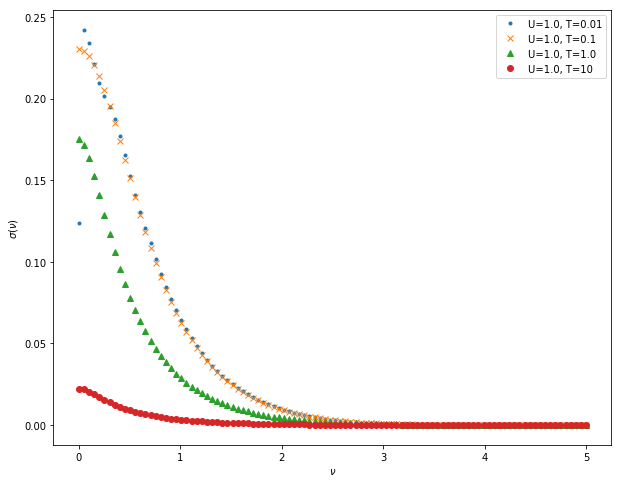

In [245]:
plt.figure(figsize = (10, 8))
plt.ylabel(r'$\sigma(\nu)$')
plt.xlabel(r'$\nu$')
plt.plot(v_list, sigma1001_list, '.', label = 'U=1.0, T=0.01')
plt.plot(v_list, sigma101_list, 'x', label = 'U=1.0, T=0.1')
plt.plot(v_list, sigma11_list, '^', label = 'U=1.0, T=1.0')
plt.plot(v_list, sigma110_list, 'o', label = 'U=1.0, T=10')
plt.legend()
plt.show()

In [119]:
sigma15001_list = []
sigma1501_list = []
sigma151_list = []
sigma1510_list = []

In [120]:
for i in range(len(v_list)):
    #print(i)
    sigma15001_list.append(sigma(v_list[i], 1.5, 0.01))
    sigma1501_list.append(sigma(v_list[i], 1.5, 0.1))
    sigma151_list.append(sigma(v_list[i], 1.5, 1.0))
    sigma1510_list.append(sigma(v_list[i], 1.5, 10.0))

C:\Users\luoge\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


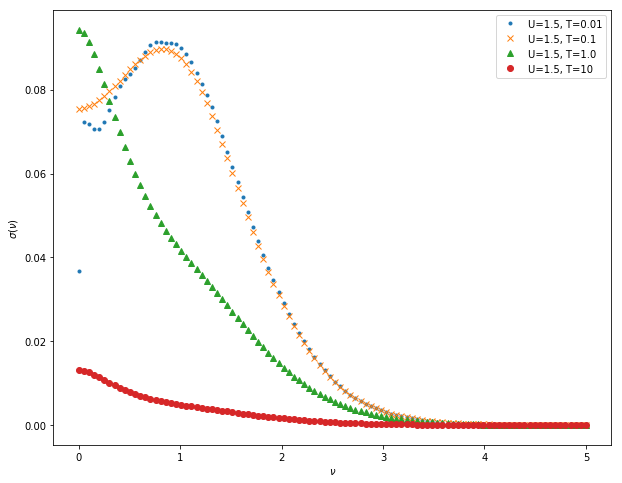

In [246]:
plt.figure(figsize = (10, 8))
plt.ylabel(r'$\sigma(\nu)$')
plt.xlabel(r'$\nu$')
plt.plot(v_list, sigma15001_list, '.', label = 'U=1.5, T=0.01')
plt.plot(v_list, sigma1501_list, 'x', label = 'U=1.5, T=0.1')
plt.plot(v_list, sigma151_list, '^', label = 'U=1.5, T=1.0')
plt.plot(v_list, sigma1510_list, 'o', label = 'U=1.5, T=10')
plt.legend()
plt.show()

In [122]:
sigma2001_list = []
sigma201_list = []
sigma21_list = []
sigma210_list = []

In [123]:
for i in range(len(v_list)):
    #print(i)
    sigma2001_list.append(sigma(v_list[i], 2.0, 0.01))
    sigma201_list.append(sigma(v_list[i], 2.0, 0.1))
    sigma21_list.append(sigma(v_list[i], 2.0, 1.0))
    sigma210_list.append(sigma(v_list[i], 2.0, 10.0))

C:\Users\luoge\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


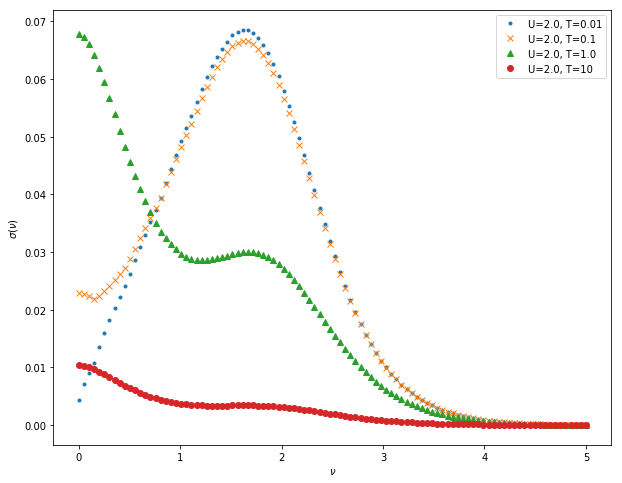

In [247]:
plt.figure(figsize = (10, 8))
plt.ylabel(r'$\sigma(\nu)$')
plt.xlabel(r'$\nu$')
plt.plot(v_list, sigma2001_list, '.', label = 'U=2.0, T=0.01')
plt.plot(v_list, sigma201_list, 'x', label = 'U=2.0, T=0.1')
plt.plot(v_list, sigma21_list, '^', label = 'U=2.0, T=1.0')
plt.plot(v_list, sigma210_list, 'o', label = 'U=2.0, T=10')
plt.legend()
plt.show()

In [126]:
def sigma_integral(U,T):
    integral_value = 0*1j
    start = 0.001
    end = 5.0
    interval = (end - start) / steps
    v = start + 0.5 * interval

    for i in range(steps):
        integral_value += sigma(v,U,T) * interval
        v += interval
    
    return integral_value * 2 / (e**2 * pi)

In [127]:
def s_int_plot(U):
    
    s_integral_list = []
    T_start = 0.001
    T_end = 2
    T_interval = (T_end - T_start) / steps
    T_temp = T_start + 0.5 * T_interval
    for i in range(steps):
        s_integral_list.append(sigma_integral(U,T_temp))
        T_temp += T_interval
    return s_integral_list

In [130]:
s_05_list = s_int_plot(0.5)

In [137]:
s_1_list = s_int_plot(1.0)
s_15_list = s_int_plot(1.5)
s_2_list = s_int_plot(2.0)

C:\Users\luoge\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


In [131]:
T_list = np.linspace(0.001, 2, num=steps)

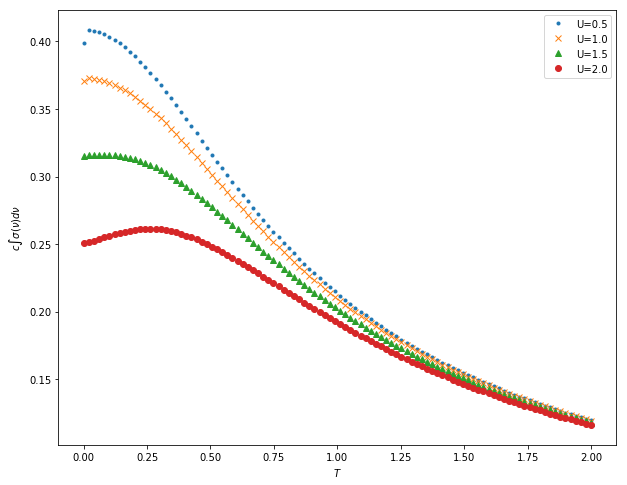

In [213]:
plt.figure(figsize = (10, 8))
plt.ylabel(r'$c\int\sigma(\nu)d\nu$')
plt.xlabel(r'$T$')
plt.plot(T_list, s_05_list, '.', label = 'U=0.5')
plt.plot(T_list, s_1_list, 'x', label = 'U=1.0')
plt.plot(T_list, s_15_list, '^', label = 'U=1.5')
plt.plot(T_list, s_2_list, 'o', label = 'U=2.0')
plt.legend()
plt.show()

In [225]:
def kinetic(U,T):
    w_start = -3
    w_end = 3
    integral_value = 0
    interval = (w_start - w_end) / steps
    w_temp = w_start + 0.5 * interval
    
    for i in range(steps):
        integral_value += (1/(1+exp(w_temp/T)) * (-1 + (w_temp+(U/2)-get_sigma(w_temp,U)) * get_gf(w_temp,U))).real * interval
        w_temp += interval
    return integral_value * (-1/pi)

In [226]:
def get_kinetic(U):
    result_list = []
    T_start = 0.001
    T_end = 2
    interval = (T_end - T_start)/ steps
    T_temp = T_start + 0.5 * interval
    
    for i in range(steps):
        result_list.append(kinetic(U,T_temp))
        T_temp += interval
    
    return result_list

In [227]:
kinetic_05 = get_kinetic(0.5)
kinetic_1 = get_kinetic(1.0)
kinetic_15 = get_kinetic(1.5)
kinetic_2 = get_kinetic(2.0)

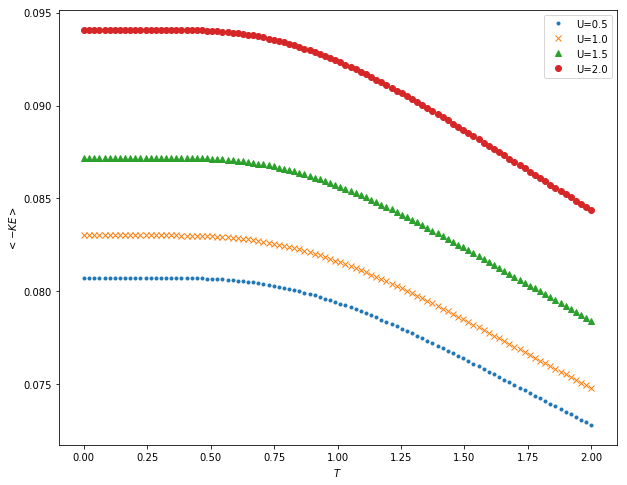

In [228]:
plt.figure(figsize = (10, 8))
plt.ylabel(r'$<-KE>$')
plt.xlabel(r'$T$')
plt.plot(T_list, kinetic_05, '.', label = 'U=0.5')
plt.plot(T_list, kinetic_1, 'x', label = 'U=1.0')
plt.plot(T_list, kinetic_15, '^', label = 'U=1.5')
plt.plot(T_list, kinetic_2, 'o', label = 'U=2.0')
plt.legend()
plt.show()

In [243]:
for i in range(len(v_list)):
    sigma05001_list[i] = sigma05001_list[i] / (e**2 * pi)
    sigma0501_list[i] = sigma0501_list[i] / (e**2 * pi)
    sigma051_list[i] = sigma051_list[i] / (e**2 * pi)
    sigma0510_list[i] = sigma0510_list[i] / (e**2 * pi)
    
    sigma1001_list[i] = sigma1001_list[i] / (e**2 * pi)
    sigma101_list[i] = sigma101_list[i] / (e**2 * pi)
    sigma11_list[i] = sigma11_list[i] / (e**2 * pi)
    sigma110_list[i] = sigma110_list[i] / (e**2 * pi)
    
    sigma15001_list[i] = sigma15001_list[i] / (e**2 * pi)
    sigma1501_list[i] =  sigma1501_list[i] / (e**2 * pi)
    sigma151_list[i] = sigma151_list[i] / (e**2 * pi)
    sigma1510_list[i] = sigma1510_list[i] / (e**2 * pi)
    
    sigma2001_list[i] = sigma2001_list[i] / (e**2 * pi)
    sigma201_list[i] = sigma201_list[i] / (e**2 * pi)
    sigma21_list[i] = sigma21_list[i] / (e**2 * pi)
    sigma210_list[i] = sigma210_list[i] / (e**2 * pi) 